In [296]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import json

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
#from mpl_toolkits.basemap import Basemap

In [278]:
sns.set()

In [208]:
firm_in_town = pd.read_csv('base_etablissement_par_tranche_effectif.csv')
salary_in_town = pd.read_csv('net_salary_per_town_categories.csv')
towns = pd.read_csv('name_geographic_information.csv')
population = pd.read_csv('population.csv')

In [264]:
geo_departments = gpd.read_file('departements.geojson')
geo_towns = gpd.read_file('communes.geojson')

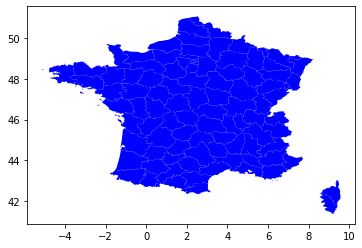

In [66]:
geo_departments.plot(color = 'blue')

Deparment code 971-976 are overseas departments

# Plotting utilities 

In [268]:
# reference: https://www.kaggle.com/skalskip/using-regression-to-predicting-earnings-in-france
def geo_plot(data_set, column, label, title):
    fig, ax = plt.subplots(1, figsize=(20,14))
    ax.set_title(title, size=32, x = 0.50, y=1.1)
    fig.patch.set_facecolor((202/255, 204/255, 206/255))
    
    # drop na
    data_cleaned = data_set.dropna(subset = ["geometry"], inplace=False)

    data_cleaned.plot(ax=ax, column=column, cmap=plt.cm.plasma, legend=True)

    for idx, row in data_cleaned.iterrows():
        plt.annotate(s=row[label], xy=row.geometry.centroid.coords[0],
                     horizontalalignment='center', color='white')

    ax.set_axis_off()

# Industrial distribution in France

First, investigate the general distribution of industrial distributions in France. 

In [265]:
firms_by_depts = firms_in_town[['DEP', 'E14TST', 'E14TS0ND', 'E14TS1',
       'E14TS6', 'E14TS10', 'E14TS20', 'E14TS50', 'E14TS100', 'E14TS200',
       'E14TS500']].groupby('DEP').sum()

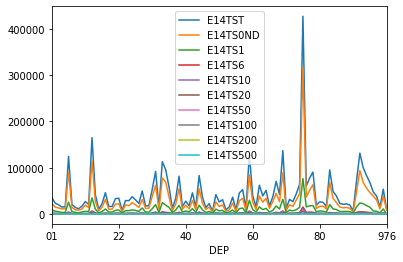

In [267]:
firms_by_depts.plot()

It is obvious that some departments are exceptionally higher than the others in terms of the total number of companies. Next, I plot the data on a map and try to get a better understanding

In [79]:
geo_firms_by_depts = geo_departments.merge(firms_by_depts, how='right', left_on='code',
                      right_on='DEP')

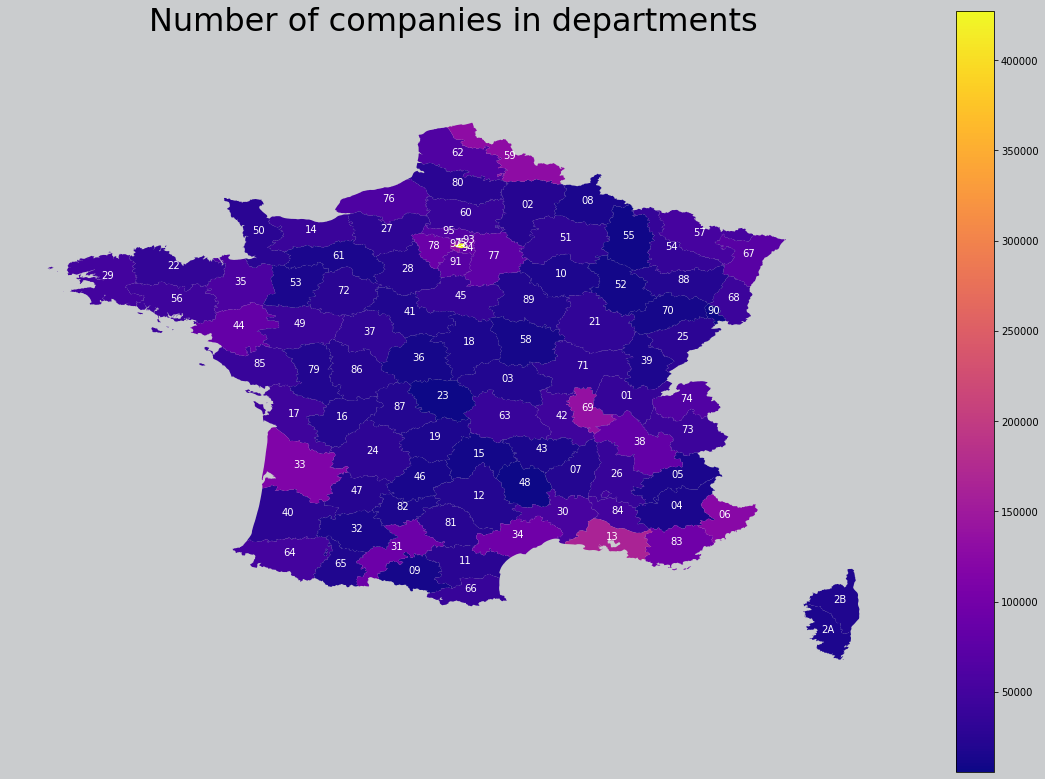

In [160]:
geo_plot(geo_firms_by_depts, "E14TST", "code", "Number of companies in departments")

We can see most of the companies are sitted in Paris area. 

Based on experience, companies with employees fewer than 50 can be categorized as small firms. Companies with employees between 50 and 500 can be considered as midium firms. Companies with employees more than 200 can be considered as big firms. 

In [270]:
geo_firms_by_depts['small'] = geo_firms_by_depts['E14TS1'] + geo_firms_by_depts['E14TS6'] + geo_firms_by_depts['E14TS10'] + geo_firms_by_depts['E14TS20']
geo_firms_by_depts['medium'] = geo_firms_by_depts['E14TS50'] + geo_firms_by_depts['E14TS100'] + geo_firms_by_depts['E14TS200']
geo_firms_by_depts['Large'] = geo_firms_by_depts['E14TS500']

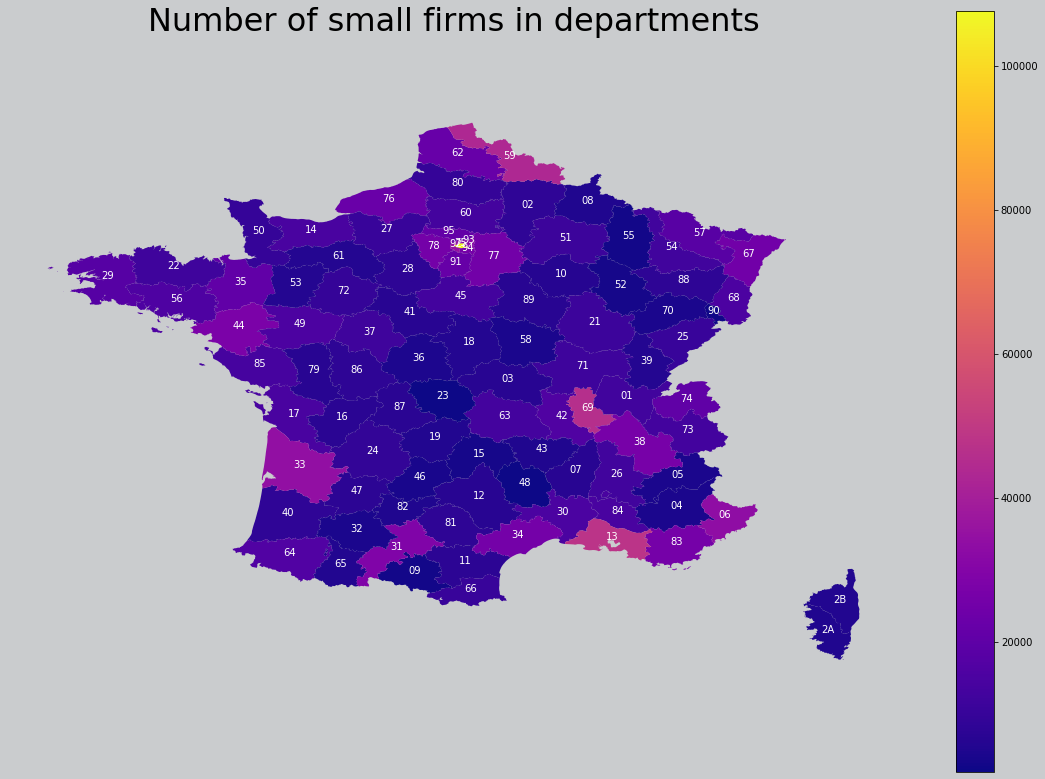

In [272]:
geo_plot(geo_firms_by_depts, "small", 'code',  "Number of small firms in departments")

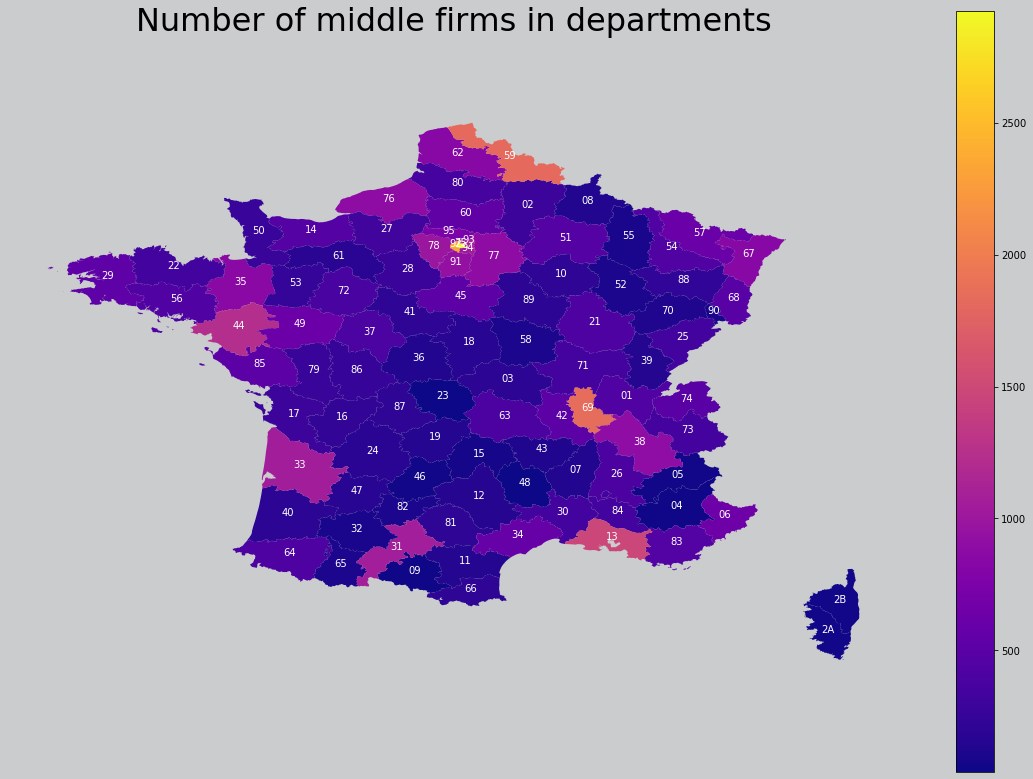

In [273]:
geo_plot(geo_firms_by_depts, "medium", 'code',  "Number of middle firms in departments")

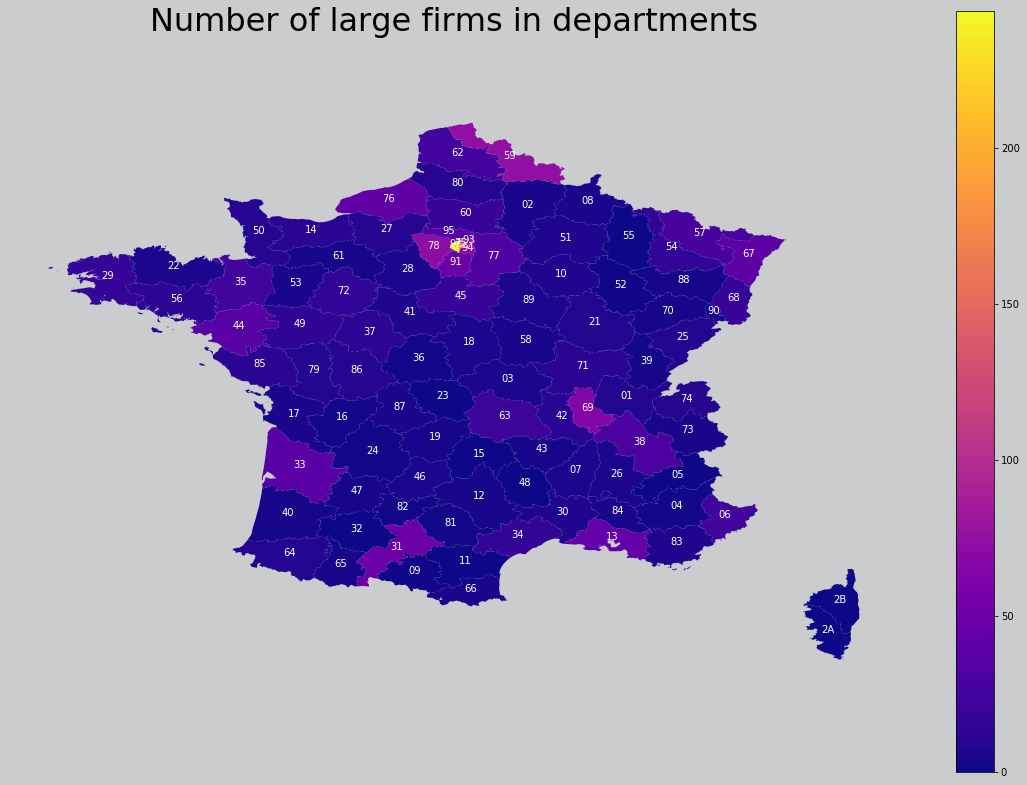

In [274]:
geo_plot(geo_firms_by_depts, "Large", 'code',  "Number of large firms in departments")

# Salaries across France

In [232]:
towns['code_insee'] = towns['code_insee'].apply(lambda x: str(x).zfill(5))

In [221]:
geo_salary_by_town = geo_towns.merge(salary_in_town, how='right', left_on='code', 
                             right_on='CODGEO')

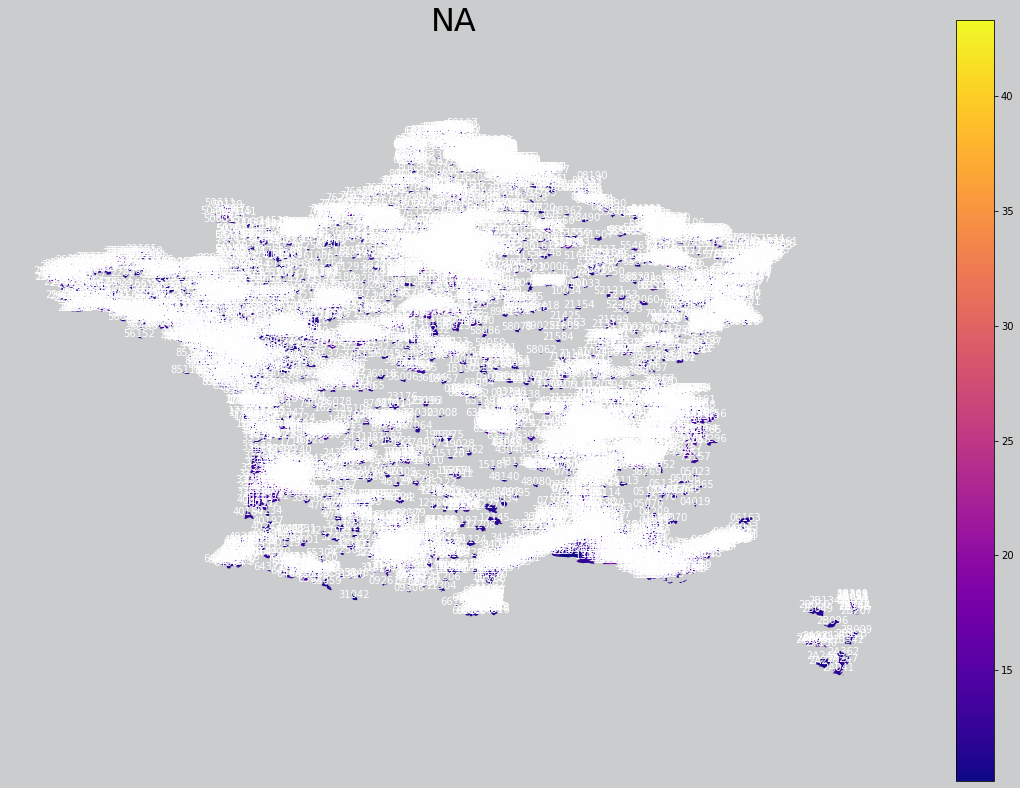

In [222]:
geo_plot(geo_salary_by_town, 'SNHM14', 'code', "NA")

It can be seen that some of the towns in France is uncoverred by the dataset, or the commune geojson file doesn't match with the salaries data. 

Thus, I further plot the salaries by departments.

In [257]:
salary_in_dept = salary_in_town.merge(towns[['code_insee', 'numéro_département']], how='left', left_on='CODGEO', right_on='code_insee')
salary_in_dept = salary_in_dept.drop(['CODGEO', 'LIBGEO', 'code_insee'], axis=1)

salary_in_dept = salary_in_dept.groupby('numéro_département', as_index=False).mean()

geo_salary_by_dept = geo_departments.merge(salary_in_dept, how='outer', left_on='code', 
                             right_on='numéro_département')

D:\Anaconda\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


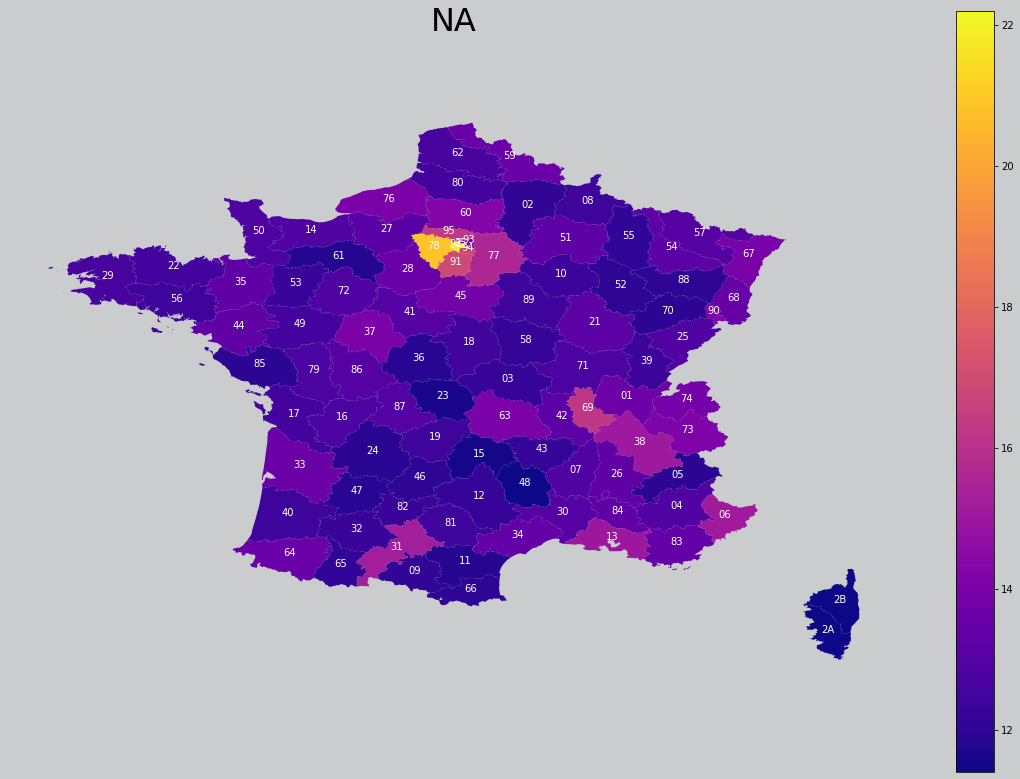

In [260]:
geo_plot(geo_salary_by_dept, 'SNHM14', 'code', "NA")

It can be seen that the mean net salaries and the number of small and medium firms in the department seems to be related. Further investigation could be done to find out more insights. In addition, more analyse could be done regarding the relation between gender, employment level, and salaries. 

# Correlations

In [305]:
geo_department_correlation = geo_firms_by_depts.merge(geo_salary_by_dept.drop(['nom', 'geometry'], axis=1), how='outer', on='code')
geo_department_correlation = geo_department_correlation.dropna(axis=0, how='any')

In [288]:
geo_department_correlation.columns

Index(['code', 'nom', 'geometry', 'E14TST', 'E14TS0ND', 'E14TS1', 'E14TS6',
       'E14TS10', 'E14TS20', 'E14TS50', 'E14TS100', 'E14TS200', 'E14TS500',
       'small', 'medium', 'Large', 'numéro_département', 'SNHM14', 'SNHMC14',
       'SNHMP14', 'SNHME14', 'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14',
       'SNHMFE14', 'SNHMFO14', 'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14',
       'SNHMHO14', 'SNHM1814', 'SNHM2614', 'SNHM5014', 'SNHMF1814',
       'SNHMF2614', 'SNHMF5014', 'SNHMH1814', 'SNHMH2614', 'SNHMH5014'],
      dtype='object')

Text(0.5, 1.01, 'Correlation between number of firms and salary')

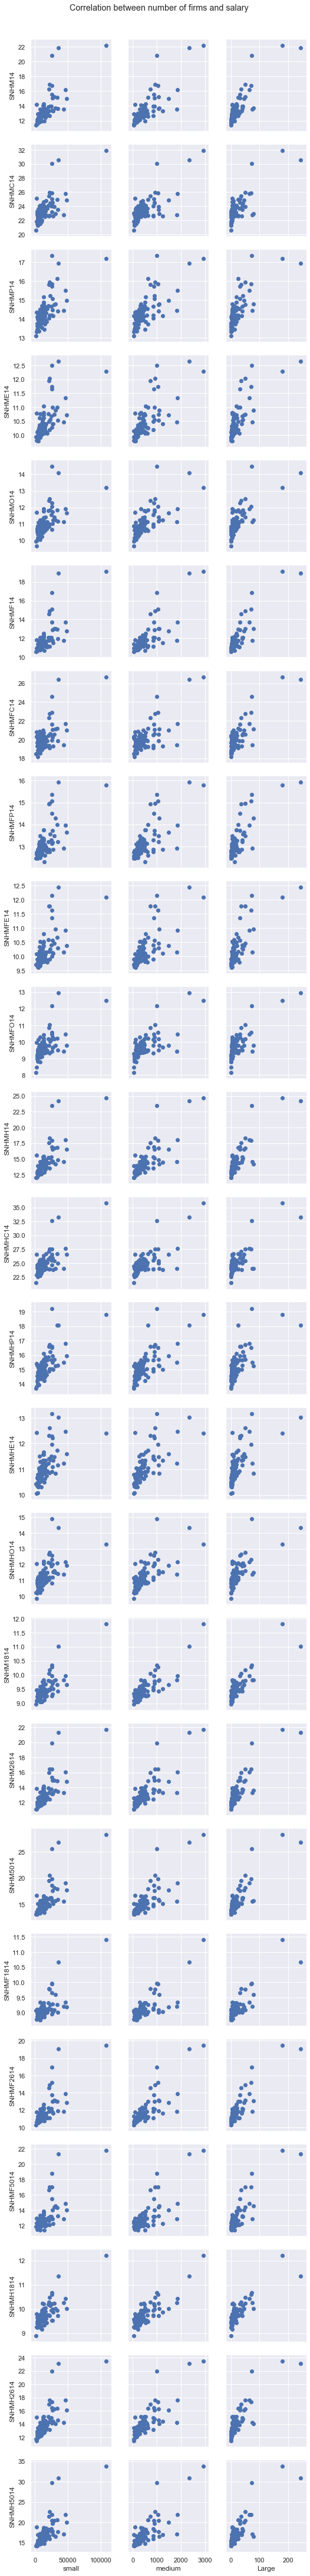

In [307]:
grid = sns.PairGrid(geo_department_correlation, 
                   x_vars=['small', 'medium', 'Large'], 
                   y_vars=['SNHM14', 'SNHMC14',
                           'SNHMP14', 'SNHME14', 'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14',
                           'SNHMFE14', 'SNHMFO14', 'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14',
                           'SNHMHO14', 'SNHM1814', 'SNHM2614', 'SNHM5014', 'SNHMF1814',
                           'SNHMF2614', 'SNHMF5014', 'SNHMH1814', 'SNHMH2614', 'SNHMH5014'])
grid = grid.map(plt.scatter)
grid.fig.suptitle("Correlation between number of firms and salary", y=1.01)

It is obvious there is a outlier. Let's check out which department has the largest number of companies

In [322]:
geo_firms_by_depts[['code', 'small']].sort_values('small', ascending=False).head(10)

,code,small
36,75,107676
70,13,48056
34,69,45886
85,59,43529
44,92,35099
54,33,34327
46,06,33386
19,93,31050
76,31,28956
80,44,27647


In [325]:
geo_firms_by_depts[['code', 'medium']].sort_values('medium', ascending=False).head(10)

,code,medium
36,75,2926
44,92,2340
34,69,1849
85,59,1821
70,13,1482
80,44,1231
19,93,1092
76,31,1072
54,33,1059
67,94,1042


In [326]:
geo_firms_by_depts[['code', 'Large']].sort_values('Large', ascending=False).head(10)

,code,Large
44,92,244
36,75,180
19,93,78
85,59,75
37,78,72
67,94,70
34,69,64
76,31,50
89,91,49
70,13,45


From the table above, department 75 seems to be outlier for small companies. For medium and large companies, department 75 and 92 are still the outliers. Thus, we remove the department 75 and 92 from the dataset. 

Text(0.5, 1.01, 'Correlation between number of firms and salary')

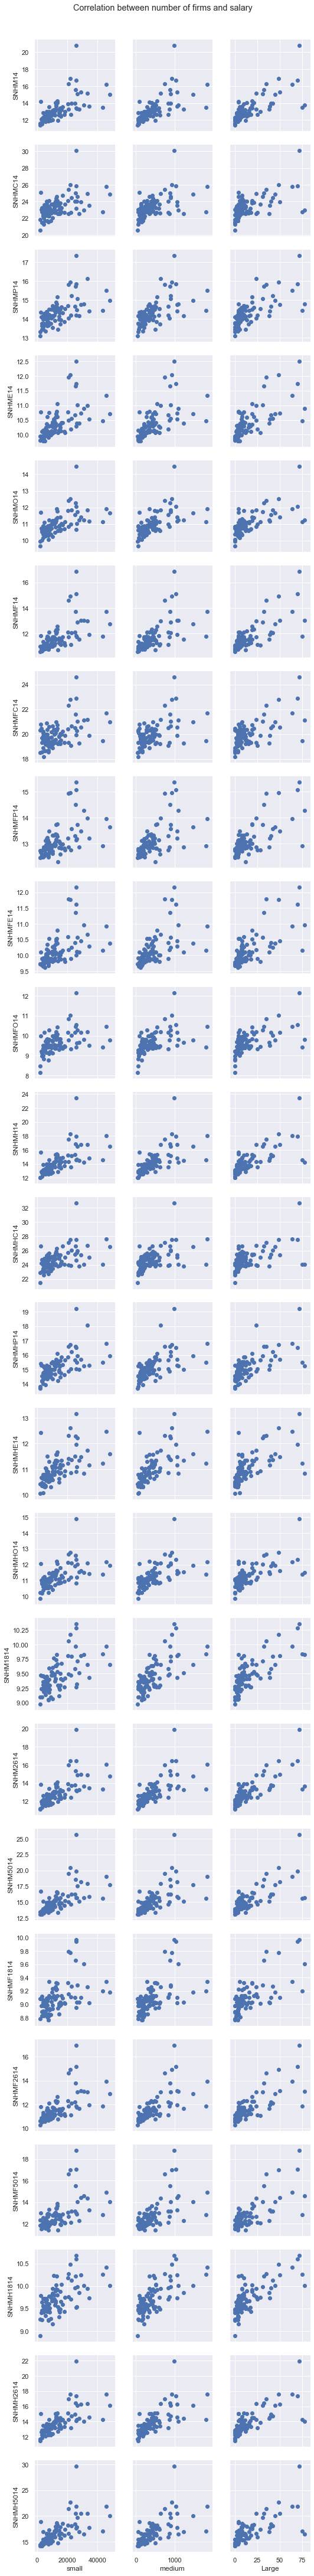

In [333]:
cleaned_geo_department_correlation = geo_department_correlation[~geo_department_correlation['code'].isin(['75','92'])] 
grid = sns.PairGrid(cleaned_geo_department_correlation, 
                   x_vars=['small', 'medium', 'Large'], 
                   y_vars=['SNHM14', 'SNHMC14',
                           'SNHMP14', 'SNHME14', 'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14',
                           'SNHMFE14', 'SNHMFO14', 'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14',
                           'SNHMHO14', 'SNHM1814', 'SNHM2614', 'SNHM5014', 'SNHMF1814',
                           'SNHMF2614', 'SNHMF5014', 'SNHMH1814', 'SNHMH2614', 'SNHMH5014'])
grid = grid.map(plt.scatter)
grid.fig.suptitle("Correlation between number of firms and salary", y=1.01)

In [334]:
salary_cates = ['SNHM14', 'SNHMC14',
'SNHMP14', 'SNHME14', 'SNHMO14', 'SNHMF14', 'SNHMFC14', 'SNHMFP14',
'SNHMFE14', 'SNHMFO14', 'SNHMH14', 'SNHMHC14', 'SNHMHP14', 'SNHMHE14',
'SNHMHO14', 'SNHM1814', 'SNHM2614', 'SNHM5014', 'SNHMF1814',
'SNHMF2614', 'SNHMF5014', 'SNHMH1814', 'SNHMH2614', 'SNHMH5014']

correlation_data = {}
for company in ['small', 'medium', 'Large']:
    correlation_data[company] = [pearsonr(cleaned_geo_department_correlation[company], cleaned_geo_department_correlation[salary])[0] for salary in salary_cates]
    
cor_matrix = pd.DataFrame(correlation_data)
cor_matrix = cor_matrix.set_index([salary_cates])

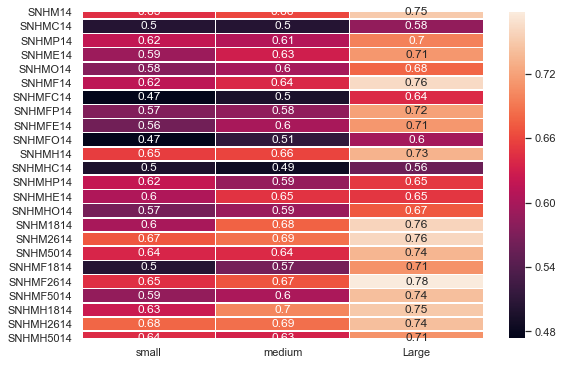

In [335]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cor_matrix, annot=True, linewidths=.5, ax=ax)

However, different from the intuition, the number of large companies in a department seems to be the most correlated with the mean net sales.